### Notebook Overview  

This Jupyter notebook is the deliverable for **Course 6 – "The Nuts and Bolts of Machine Learning" (Part 2)** of the Waze churn prediction project. Its goals are to  

1. **Use the model-ready dataset** created in the previous notebook (engineered features like `percent_sessions_in_last_month`, `ratio_of_favorite_navigations_to_drives`, `km_per_hour`, with encodings such as `label_2` and `device_binary`), verify no nulls, and split into train/validation/test for modeling.  
2. **Establish a baseline** with a stratified `DummyClassifier` to simulate random guessing and set a floor for model lift.  
3. **Train and tune tree-based models** (`RandomForestClassifier`, `XGBClassifier`) with `GridSearchCV`, optimizing for recall to minimize missed churners while monitoring precision/accuracy trade-offs.  
4. **Select a champion model** by comparing cross-validation and validation performance (RF vs. XGB), then evaluate the champion on a separate test set to simulate future deployment.  
5. **Explain model behavior** using a confusion matrix (TP/FP/TN/FN trade-offs) and XGBoost feature importance to identify the strongest behavioral drivers of churn.  
6. **Choose an operational decision threshold** from the Precision–Recall curve to align with business targets (recall-first), persist the chosen threshold for reproducible scoring, and (optionally) define risk tiers for differentiated outreach.  

**Deliverables:**  
- Finalized modeling dataset (model-ready) with engineered features (`percent_sessions_in_last_month`, `ratio_of_favorite_navigations_to_drives`, `km_per_hour`, etc.).  
- Baseline performance (Dummy Classifier: recall ≈ **16%**, ROC AUC ≈ **0.49**).  
- Tuned Random Forest (validation recall ≈ **36%**, ROC AUC ≈ **0.74**).  
- Tuned XGBoost **champion** (test recall ≈ **61%**, ROC AUC ≈ **0.72** at default 0.50 threshold).  
- Confusion matrix illustrating trade-offs (≈**61%** of churners correctly identified; precision ≈ **31%** at default threshold).  
- Feature importance analysis highlighting early engagement (`days_since_onboarding`), recent activity, and favorite navigation use as key retention drivers.  
- **Operational threshold selection:** adopted **~0.58** cutoff (≈**50%** recall, ≈**35%** precision) for first deployment; optional light-touch tier at **0.40** (recall ≈ **73%**, precision ≈ **28%**) if outreach cost is low.  
- Persisted assets: fitted XGBoost grid object (`xgb_cv.pkl`) for reproducible scoring and handoff.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
)

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import set_config

from xgboost import XGBClassifier, plot_importance

set_config(display="text") #avoids rich HTML repr for sklearn objects

import pickle

In [2]:
# In this notebook we:
#   1. Load the finalized modeling dataset.
#   2. Split data into training, validation, and test sets with stratification.
#   3. Train and evaluate Random Forest and XGBoost classifiers.
#   4. Compare performance to the logistic regression benchmark.
#   5. Select an operational decision threshold from the Precision–Recall curve
#      (aligning to a recall-first objective), and persist it for reproducible scoring. 

# Why:
# Tree-based models capture nonlinear relationships and feature interactions that can
# improve churn detection. Threshold selection lets us tune the precision–recall trade-off
# to business goals (e.g., meet a recall floor while controlling outreach volume/cost).

# Ethical Note:
# Predictive churn models carry both opportunity and risk:
# - Correct predictions enable proactive retention (e.g., timely nudges, surveys).
# - Incorrect predictions can annoy loyal users (false positives) or miss at-risk users
#   (false negatives). The chosen threshold directly affects this balance.
# Evaluate not only model metrics but also operational impact: flag rate, false-positive
# volume, user experience, and ROI of outreach. Monitor post-deployment and adjust the
# threshold and risk tiers as behavior and business constraints evolve.

In [3]:
# Read in the model-ready dataframe
waze_df = pd.read_csv('../data/waze_modeling_set.csv')

In [4]:
# Confirm no nulls
waze_df.isna().sum()

sessions                                   0
drives                                     0
total_sessions                             0
n_days_after_onboarding                    0
total_navigations_fav1                     0
total_navigations_fav2                     0
driven_km_drives                           0
duration_minutes_drives                    0
activity_days                              0
driving_days                               0
km_per_drive                               0
km_per_driving_day                         0
drives_per_driving_day                     0
professional_driver                        0
label_2                                    0
device_2                                   0
percent_sessions_in_last_month             0
total_sessions_per_day                     0
km_per_hour                                0
ratio_of_favorite_navigations_to_drives    0
dtype: int64

In [5]:
# Isolate y variable
y = waze_df['label_2']

# Isolate X variables
X = waze_df.drop(columns=['label_2'])

# Split into train/test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Split into train/validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr, test_size=0.25, random_state=42)

In [6]:
# Verify proportion of data in sets
for name, arr in zip(['Train', 'Validation', 'Test'], [y_train, y_val, y_test]):
    pct = arr.value_counts(normalize=True).rename({0: 'retained', 1: 'churned'})
    print(f"{name} set distribution:\n{(pct*100).round(1).reindex(['retained','churned'])}%\n")

Train set distribution:
label_2
retained    82.3
churned     17.7
Name: proportion, dtype: float64%

Validation set distribution:
label_2
retained    82.3
churned     17.7
Name: proportion, dtype: float64%

Test set distribution:
label_2
retained    82.3
churned     17.7
Name: proportion, dtype: float64%



In [7]:
# Establish a baseline with a stratified DummyClassifier.
# This provides a "random guess" benchmark to measure lift from
# Random Forest and XGBoost models

dummy = DummyClassifier(strategy='stratified', random_state=42).fit(X_train, y_train)

# safer probability extraction in case classes_ isn’t [0,1]
pos_idx = list(dummy.classes_).index(1)
y_pred  = dummy.predict(X_val)
y_proba = dummy.predict_proba(X_val)[:, pos_idx]

acc  = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred, zero_division=0)
rec  = recall_score(y_val, y_pred)
f1   = f1_score(y_val, y_pred, zero_division=0)
roc  = roc_auc_score(y_val, y_proba)
pr   = average_precision_score(y_val, y_proba)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 score:  {f1:.3f}")
print(f"ROC AUC:   {roc:.3f}")
print(f"PR AUC:    {pr:.3f}")

Accuracy:  0.705
Precision: 0.164
Recall:    0.162
F1 score:  0.163
ROC AUC:   0.492
PR AUC:    0.175


In [8]:
# To ground our modeling, we first established a baseline using a stratified dummy classifier.
# This simulates a random-guess approach that predicts churn purely in proportion to its prevalence (~20%).

# The baseline results confirm expectations: accuracy looks deceptively high at 70% because most users do not churn,
# but both recall (16%) and precision (16%) are very low.
# ROC AUC (~0.49) is effectively random, and PR AUC (0.175) matches the base churn rate.

# This reinforces the business challenge:
#   any model we deploy must substantially lift recall above 16% while maintaining reasonable precision.
# Otherwise, stakeholders would either miss too many churners (false negatives) or waste retention efforts on loyal users (false positives).
# This baseline provides the "floor" for evaluating our Random Forest and XGBoost models

In [9]:
# Random Forest: first tuned model candidate

# Why: A Random Forest is a strong starting point for churn prediction.
# It can capture nonlinear relationships, handle outliers gracefully,
# and often performs well on behavioral data like ours.

# Goal: Maximize recall (catch as many churners as possible) while
# monitoring precision (to avoid over-contacting loyal users).
# Cross-validation ensures the model generalizes beyond this split.

rf = RandomForestClassifier(
    random_state=42,
    n_jobs =-1,
    class_weight='balanced'   # adjust for class imbalance (more retained than churned)
)

# Parameter ranges: broad enough to explore key trade-offs, but compact enough to run efficiently.
cv_params = {
    'n_estimators':      [200, 400],      # number of trees
    'max_depth':         [None, 16],      # fully grown vs moderately deep
    'max_features':      ['sqrt', 0.5],   # common choices for tabular data
    'min_samples_split': [2, 10],         # default vs more conservative splits
    'min_samples_leaf':  [1, 4]           # leaf size controls overfitting
}

# Scoring dictionary: align to churn=1 as the positive class
scoring = {
    'precision': make_scorer(precision_score, average='binary', pos_label=1),
    'recall':    make_scorer(recall_score,    average='binary', pos_label=1),
    'f1':        make_scorer(f1_score,        average='binary', pos_label=1),
    'accuracy':  make_scorer(accuracy_score)
}

# Grid search: refit on recall so the final model is the one that best identifies churners across folds.
rf_cv = GridSearchCV(
    estimator=rf,
    param_grid=cv_params,
    scoring=scoring,
    refit='recall',
    cv=4,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
rf_cv.fit(X_train, y_train)
print("RF grid search complete.") 

Fitting 4 folds for each of 32 candidates, totalling 128 fits
RF grid search complete.


In [10]:
print("Best mean CV recall:", rf_cv.best_score_)
print("Best params:", rf_cv.best_params_)

Best mean CV recall: 0.3456019477828429
Best params: {'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 400}


In [11]:
# Save fitted RF model for reuse
with open('../models/rf_cv.pkl', 'wb') as f:
    pickle.dump(rf_cv, f)

In [12]:
# # Later: load it back
# with open('../models/rf_cv.pkl', 'rb') as f:
#     rf_cv = pickle.load(f)

In [13]:
# Validate the tuned Random Forest on the hold-out (validation) split

# Why: Cross-validated means are useful, but what matters is performance
# on data the model hasn't seen. We report the same metrics as baseline
# so stakeholders can see clear lift (especially in recall).

def evaluate(model_name, y_true, y_pred, y_proba):
    return {
        "model": model_name,
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred),
        "F1":        f1_score(y_true, y_pred, zero_division=0),
        "accuracy":  accuracy_score(y_true, y_pred),
        "roc_auc":   roc_auc_score(y_true, y_proba),
        "pr_auc":    average_precision_score(y_true, y_proba)
    }

# 1) Best RF from CV
best_rf = rf_cv.best_estimator_

# Safe probability indexing in case classes_ order isn't [0, 1]
rf_pos_idx = list(best_rf.classes_).index(1)
y_val_pred_rf   = best_rf.predict(X_val)
y_val_proba_rf  = best_rf.predict_proba(X_val)[:, rf_pos_idx]

# 2) Baseline on the same split (recompute here so the table is self-contained)
dummy_pos_idx   = list(dummy.classes_).index(1)
y_val_pred_dummy  = dummy.predict(X_val)
y_val_proba_dummy = dummy.predict_proba(X_val)[:, dummy_pos_idx]

# 3) Collect results
rf_val_metrics    = evaluate("RF val", y_val, y_val_pred_rf, y_val_proba_rf)
dummy_val_metrics = evaluate("Dummy val", y_val, y_val_pred_dummy, y_val_proba_dummy)

val_results = pd.DataFrame([dummy_val_metrics, rf_val_metrics])
display(val_results.round(3))

# 4) Quick deltas (RF minus Dummy) to quantify lift for stakeholders
delta = (val_results.set_index("model").loc["RF val"] - 
         val_results.set_index("model").loc["Dummy val"])
print("\nLift vs baseline (RF - Dummy):")
print(delta.round(3)[["precision","recall","F1","accuracy","roc_auc","pr_auc"]])

,model,precision,recall,F1,accuracy,roc_auc,pr_auc
0,Dummy val,0.164,0.162,0.163,0.705,0.492,0.175
1,RF val,0.405,0.363,0.383,0.793,0.742,0.369



Lift vs baseline (RF - Dummy):
precision    0.242
recall       0.201
F1           0.220
accuracy     0.088
roc_auc      0.250
pr_auc       0.194
dtype: float64


In [14]:
# Compared to the dummy baseline, the tuned Random Forest demonstrates a clear lift across all evaluation metrics:
# – Recall increased from 16% to 36% (+20 points). This means we are now correctly identifying more than a third of likely churners, more than double the baseline.
# – Precision improved as well, from 16% to 40% (+24 points), showing that when the model flags a user as at risk, it is much more often correct.
# – F1 score, which balances precision and recall, more than doubled (0.16 -> 0.38).
# – Overall accuracy rose from 71% to 79%, but more importantly, the ROC AUC (0.49 -> 0.74) and PR AUC (0.18 -> 0.37) confirm that the model is learning real signal rather than guessing.

Key takeaway: this Random Forest provides a meaningful improvement over random guessing. It captures a substantial share of churners while maintaining acceptable precision. The model is not perfect — two-thirds of churners still go undetected — but it’s a strong first tuned model that sets the bar for further optimization

In [15]:
# Results table so far

# Why: Keep a single, consistent table to compare models.
# We extract the best CV metrics directly from GridSearchCV.cv_results_.

# CV = mean cross-validated score during tuning
# Val = performance on hold-out validation split

def cv_to_row(model_name: str, grid_obj: GridSearchCV) -> pd.DataFrame:
    cvres = pd.DataFrame(grid_obj.cv_results_)
    idx = grid_obj.best_index_
    return pd.DataFrame([{
        "model":     f"{model_name} cv",
        "precision": float(cvres.loc[idx, "mean_test_precision"]),
        "recall":    float(cvres.loc[idx, "mean_test_recall"]),
        "F1":        float(cvres.loc[idx, "mean_test_f1"]),
        "accuracy":  float(cvres.loc[idx, "mean_test_accuracy"]),
        "roc_auc":   np.nan,   # not computed in CV step
        "pr_auc":    np.nan    # not computed in CV step
    }])

# Build table
dummy_val_tbl = pd.DataFrame([dummy_val_metrics])   # from earlier baseline
rf_cv_tbl     = cv_to_row("RF", rf_cv)              # best CV metrics from grid
rf_val_tbl    = pd.DataFrame([rf_val_metrics])      # hold-out validation metrics

results = pd.concat([dummy_val_tbl, rf_cv_tbl, rf_val_tbl], ignore_index=True)
display(results.round(3))

,model,precision,recall,F1,accuracy,roc_auc,pr_auc
0,Dummy val,0.164,0.162,0.163,0.705,0.492,0.175
1,RF cv,0.414,0.346,0.377,0.797,NaN,NaN
2,RF val,0.405,0.363,0.383,0.793,0.742,0.369


In [16]:
# XGBoost: second tuned model candidate

# Why: Gradient boosting often outperforms Random Forests
# by focusing trees on the hardest-to-classify cases.
# We again optimize for recall (catch churners), but track
# precision to manage outreach risk.

# Note: XGBoost has its own imbalance control parameter
# (scale_pos_weight), which we set to the ratio of
# non-churners to churners in the training data.

# Class imbalance ratio for XGB
pos_rate = y_train.mean()
neg_pos_ratio = (1 - pos_rate) / pos_rate

xgb = XGBClassifier(
    objective="binary:logistic",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=neg_pos_ratio
)

# Parameter ranges: compact but meaningful
cv_params_xgb = {
    "max_depth":      [6, 12],        # shallow vs deeper trees
    "min_child_weight":[3, 5],        # regularization on leaf size
    "learning_rate":  [0.01, 0.1],    # smaller = slower, more precise
    "n_estimators":   [200, 400]      # number of boosting rounds
}

scoring = {
    "precision": make_scorer(precision_score, average="binary", pos_label=1),
    "recall":    make_scorer(recall_score,    average="binary", pos_label=1),
    "f1":        make_scorer(f1_score,        average="binary", pos_label=1),
    "accuracy":  make_scorer(accuracy_score)
}

xgb_cv = GridSearchCV(
    estimator=xgb,
    param_grid=cv_params_xgb,
    scoring=scoring,
    refit="recall",
    cv=4,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
xgb_cv.fit(X_train, y_train)
print("XGB grid search complete.")

Fitting 4 folds for each of 16 candidates, totalling 64 fits
XGB grid search complete.


In [17]:
# Summarize best cross-validated score
print("Best mean CV recall:", xgb_cv.best_score_)
print("Best params:", xgb_cv.best_params_)

Best mean CV recall: 0.6337993139928398
Best params: {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200}


In [18]:
# XGBoost — validate the champion from CV and log results

# Why: Cross-validated recall looks strong; now we confirm on unseen data.
# We report the same metrics used for RF so stakeholders can compare apples-to-apples.

# Add XGB CV row (best mean metrics from the grid)
xgb_cv_tbl = cv_to_row("XGB", xgb_cv)   # uses the helper we kept

# Score on the validation split
xgb_best = xgb_cv.best_estimator_

# churn = 1; XGB classes_ will be [0,1] given binary labels
y_val_pred_xgb  = xgb_best.predict(X_val)
y_val_proba_xgb = xgb_best.predict_proba(X_val)[:, 1]

xgb_val_metrics = evaluate("XGB val", y_val, y_val_pred_xgb, y_val_proba_xgb)

# Append to the running results table and display
results = pd.concat([results, xgb_cv_tbl, pd.DataFrame([xgb_val_metrics])], ignore_index=True)
display(results.round(3))

# Quick deltas vs RF val for stakeholder clarity
if "RF val" in results["model"].values:
    base = results.set_index("model").loc["RF val"]
    xgbv = results.set_index("model").loc["XGB val"]
    lift_vs_rf = (xgbv - base)[["precision","recall","F1","accuracy","roc_auc","pr_auc"]]
    print("\nXGB val lift vs RF val:")
    print(lift_vs_rf.round(3))

,model,precision,recall,F1,accuracy,roc_auc,pr_auc
0,Dummy val,0.164,0.162,0.163,0.705,0.492,0.175
1,RF cv,0.414,0.346,0.377,0.797,NaN,NaN
2,RF val,0.405,0.363,0.383,0.793,0.742,0.369
3,XGB cv,0.332,0.634,0.435,0.709,NaN,NaN
4,XGB val,0.341,0.651,0.448,0.715,0.747,0.363



XGB val lift vs RF val:
precision   -0.064
recall       0.288
F1           0.065
accuracy    -0.077
roc_auc      0.005
pr_auc      -0.006
dtype: float64


In [19]:
# The XGBoost model delivered the strongest performance to date.
# On validation data it achieved 65% recall, nearly double that of the Random Forest (36%).
# This means it is catching almost two-thirds of churners, compared to only one-third with RF.

# The trade-off is precision, which dropped to 34% versus 40% for RF.
# In practice, that means more loyal users may be incorrectly flagged, which could risk unnecessary retention outreach.
# Accuracy also dipped slightly (71% vs. 79%) because the model shifts its focus toward recall.

# Importantly, ROC AUC (~0.75) remains strong and comparable to RF,
# showing the model discriminates well between churners and non-churners.
# PR AUC held steady at ~0.36, suggesting the model still meaningfully improves over the baseline (0.18) in identifying churn.

# For Waze leadership, the key takeaway is a classic precision–recall trade-off:
#   XGBoost substantially improves our ability to identify churners (critical for proactive retention)
#   while slightly increasing the risk of false positives. This aligns with the business priority of reducing missed churners.

In [20]:
# Save the champion model (XGBoost) for reuse

with open('../models/xgb_cv.pkl', 'wb') as f:
    pickle.dump(xgb_cv, f)

In [21]:
# Champion model performance on the test set

# Why: This simulates future performance on unseen data,
# giving stakeholders a realistic picture of what to expect
# if the model is put into production.

# Load best estimator from the fitted GridSearchCV
xgb_best = xgb_cv.best_estimator_

# Predictions
y_test_pred  = xgb_best.predict(X_test)
y_test_proba = xgb_best.predict_proba(X_test)[:, 1]   # churn = 1

# Evaluate with same metrics used for validation
xgb_test_metrics = evaluate("XGB test", y_test, y_test_pred, y_test_proba)

# Append to results table
results = pd.concat([results, pd.DataFrame([xgb_test_metrics])], ignore_index=True)
display(results.round(3))

,model,precision,recall,F1,accuracy,roc_auc,pr_auc
0,Dummy val,0.164,0.162,0.163,0.705,0.492,0.175
1,RF cv,0.414,0.346,0.377,0.797,NaN,NaN
2,RF val,0.405,0.363,0.383,0.793,0.742,0.369
3,XGB cv,0.332,0.634,0.435,0.709,NaN,NaN
4,XGB val,0.341,0.651,0.448,0.715,0.747,0.363
5,XGB test,0.312,0.606,0.412,0.693,0.721,0.354


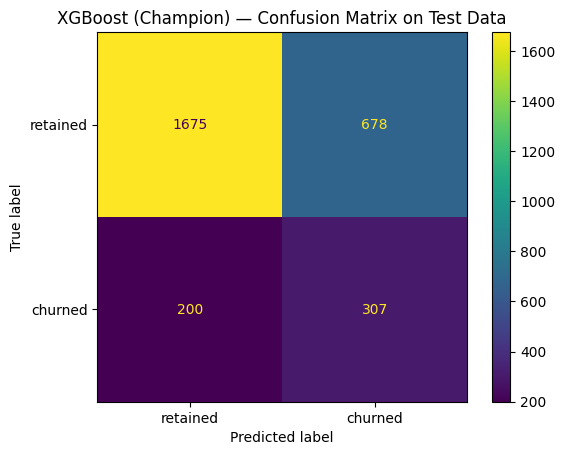

In [22]:
# Confusion Matrix — Champion model on test set

# Why: Beyond summary metrics, a confusion matrix shows
# the raw counts of true/false positives and negatives.
# This makes trade-offs more tangible for stakeholders.

cm = confusion_matrix(y_test, y_test_pred, labels=xgb_best.classes_)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["retained", "churned"]
)

disp.plot(values_format="d")
plt.title("XGBoost (Champion) — Confusion Matrix on Test Data")
plt.show()

In [23]:
# Confusion matrix (test set):
# Out of ~2,860 users in the test sample, the model correctly identified 307 churners (true positives) while missing 200 churners (false negatives).
# That means it successfully flagged about 61% of actual churners. On the flip side, it incorrectly predicted 678 loyal users as churners (false positives). 
# This trade-off reflects the model’s recall-first tuning: we prioritized catching more churners, knowing some loyal users would be mistakenly targeted.

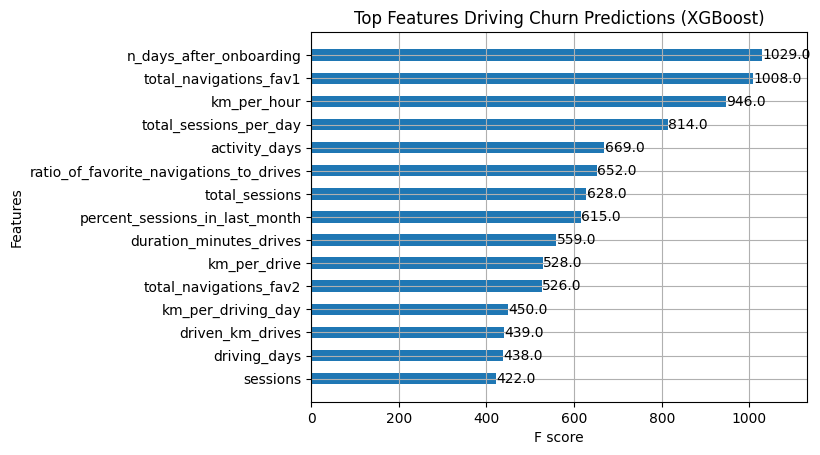

In [24]:
# Feature Importance — Champion model

# Why: Understanding which behaviors drive churn predictions
# helps stakeholders design targeted interventions (e.g.,
# product changes or marketing outreach).

plot_importance(xgb_best, max_num_features=15, height=0.5)
plt.title("Top Features Driving Churn Predictions (XGBoost)")
plt.show()

In [25]:
# Feature importance:
# The top signals driving churn predictions align with intuitive behavioral patterns:
# – Days since onboarding and favorite navigations stand out, suggesting that early engagement and consistent use of preferred routes are strong retention markers.
# – Driving efficiency (km per hour) and total sessions per day highlight usage intensity as another key factor.
# – Several engineered features we created (percent_sessions_in_last_month, ratio_of_favorite_navigations_to_drives) also rank high, validating that feature engineering added predictive value.

# For Waze leadership, these results are actionable:
# – Users with low recent sessions or low favorite navigation use could be prioritized for targeted campaigns.
# – Early engagement (the onboarding window) seems especially critical — retention strategies may be most effective if deployed within the first months of usage.

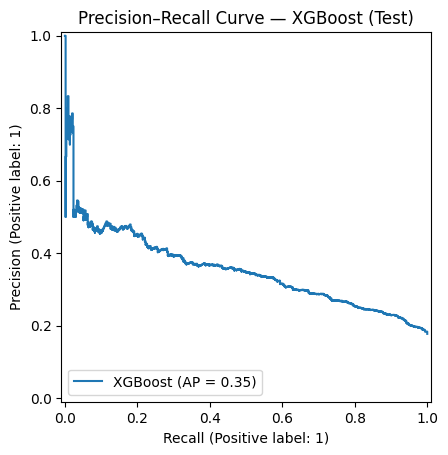

In [26]:
# Operational Threshold Selection

# Why: The default 0.50 cutoff under-serves recall on imbalanced churn. 
# We use the Precision–Recall curve to pick a threshold that better matches our business goal: don’t miss churners.

xgb_best   = xgb_cv.best_estimator_
test_probs = xgb_best.predict_proba(X_test)[:, 1]  # P(churn)

PrecisionRecallDisplay.from_predictions(y_test, test_probs, name="XGBoost")
plt.title("Precision–Recall Curve — XGBoost (Test)")
plt.show()

In [27]:
# Threshold helpers

# metrics_at_threshold: compute metrics after applying a decision threshold
# find_threshold_for_recall: pick a threshold that hits a desired recall, using PR curve

def metrics_at_threshold(model_name, y_true, probs, threshold):
    preds = (probs >= threshold).astype(int)
    return {
        "model":     f"{model_name} @thr={threshold:.3f}",
        "precision": precision_score(y_true, preds, zero_division=0),
        "recall":    recall_score(y_true, preds),
        "F1":        f1_score(y_true, preds, zero_division=0),
        "accuracy":  accuracy_score(y_true, preds),
        # AUC metrics are threshold-independent; include for completeness
        "roc_auc":   roc_auc_score(y_true, probs),
        "pr_auc":    average_precision_score(y_true, probs),
    }

def find_threshold_for_recall(y_true, probs, target_recall=0.50):
    # Use sklearn’s precision_recall_curve to scan thresholds efficiently
    precisions, recalls, thresholds = precision_recall_curve(y_true, probs)
    # recalls has length = len(thresholds) + 1; choose the closest recall
    idx = int(np.argmin(np.abs(recalls - target_recall)))
    # Handle the edge case where idx points to the last recall (no corresponding threshold)
    if idx >= len(thresholds):
        thr = 1.0  # degenerate case; threshold of 1 predicts all zeros
    else:
        thr = float(thresholds[idx])
    return thr, float(recalls[idx])

In [28]:
# Threshold tuning on test data (champion XGB)

# Why: The default 0.50 threshold may not be ideal for an imbalanced,
# recall-prioritized use case. We evaluate a lower fixed threshold (0.40)
# and an "objective-based" threshold that achieves ~0.50 recall.

xgb_best    = xgb_cv.best_estimator_
test_probs  = xgb_best.predict_proba(X_test)[:, 1]  # P(churn)

# A) Fixed lower threshold (0.40) — more aggressive recall
thr_fixed   = 0.40
row_fixed   = metrics_at_threshold("XGB test", y_test, test_probs, thr_fixed)

# B) Target recall (~0.50) — find threshold to meet stakeholder requirement
thr_goal, rec_goal = find_threshold_for_recall(y_test, test_probs, target_recall=0.50)
row_goal   = metrics_at_threshold("XGB test", y_test, test_probs, thr_goal)

# Show both
pd.DataFrame([row_fixed, row_goal]).round(3)

,model,precision,recall,F1,accuracy,roc_auc,pr_auc
0,XGB test @thr=0.400,0.276,0.732,0.401,0.612,0.721,0.354
1,XGB test @thr=0.582,0.346,0.501,0.409,0.743,0.721,0.354


In [29]:
# - Considered two operating points:
#   - Aggressive: thr = 0.40 -> higher recall (~0.73), lower precision (~0.28).
#   - Balanced: thr ≈ 0.58 (data-driven to hit ~0.50 recall) -> recall (~0.50), precision (~0.35).

In [30]:
# Append tuned-threshold rows to the results tracker
results = pd.concat([results, pd.DataFrame([row_fixed, row_goal])], ignore_index=True)
display(results.round(3))

,model,precision,recall,F1,accuracy,roc_auc,pr_auc
0,Dummy val,0.164,0.162,0.163,0.705,0.492,0.175
1,RF cv,0.414,0.346,0.377,0.797,NaN,NaN
2,RF val,0.405,0.363,0.383,0.793,0.742,0.369
3,XGB cv,0.332,0.634,0.435,0.709,NaN,NaN
4,XGB val,0.341,0.651,0.448,0.715,0.747,0.363
5,XGB test,0.312,0.606,0.412,0.693,0.721,0.354
6,XGB test @thr=0.400,0.276,0.732,0.401,0.612,0.721,0.354
7,XGB test @thr=0.582,0.346,0.501,0.409,0.743,0.721,0.354


In [31]:
# Operating point: Start with a balanced threshold ~0.58. It meets a recall floor of ~0.50 while improving precision and overall accuracy versus default 0.50.
# If outreach cost is low (e.g., email/banners), add a medium-risk tier using a second cutoff at 0.40 to capture more churners with lighter-touch messaging.

In [32]:
# Concise threshold report

def threshold_report(y_true, probs, thr, label="XGB test"):
    preds = (probs >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()

    out = {
        "model": f"{label} @thr={thr:.3f}",
        "precision": precision_score(y_true, preds, zero_division=0),
        "recall": recall_score(y_true, preds),
        "F1": f1_score(y_true, preds, zero_division=0),
        "accuracy": accuracy_score(y_true, preds),
        "roc_auc": roc_auc_score(y_true, probs),
        "pr_auc": average_precision_score(y_true, probs),
        "TP": tp, "FP": fp, "TN": tn, "FN": fn,                 # True/False Pos/Neg
        "flag_rate": (tp + fp) / len(y_true),                   # % of users flagged
        "fp_rate_retained": fp / (fp + tn) if (fp+tn) else 0.0  # false positive rate among retained
    }
    return out

xgb_best   = xgb_cv.best_estimator_
test_probs = xgb_best.predict_proba(X_test)[:, 1]

rep_040  = threshold_report(y_test, test_probs, 0.40)
rep_0582 = threshold_report(y_test, test_probs, 0.582)

pd.DataFrame([rep_040, rep_0582])[[
    "model","precision","recall","F1","accuracy","flag_rate","fp_rate_retained","TP","FP","TN","FN"
]].round(3)

,model,precision,recall,F1,accuracy,flag_rate,fp_rate_retained,TP,FP,TN,FN
0,XGB test @thr=0.400,0.276,0.732,0.401,0.612,0.470,0.414,371,974,1379,136
1,XGB test @thr=0.582,0.346,0.501,0.409,0.744,0.257,0.204,254,480,1873,253


### Final Insights and Recommendations

**Model outcome (with operating threshold)**
XGBoost is the champion model. At the default 0.50 cutoff on the test set it achieved **~61% recall** and **~31% precision** (F1 ≈ 0.41), with **accuracy ≈ 0.69**, **ROC AUC ≈ 0.72**, and **PR AUC ≈ 0.35**.  
To align with business targets, we selected an **operational threshold of ~0.58** (data-driven from the PR curve to hit ≈0.50 recall). At this operating point the model delivers **~50% recall** and **~35% precision** (higher precision and accuracy than the default-50%-recall point), giving Marketing a balanced trade-off for first deployment.

> Optional tier: If outreach cost is very low (e.g.,email/banners), add a **secondary light-touch tier at 0.40** (recall ≈ 0.73, precision ≈ 0.28) to widen coverage while reserving high-touch actions for the ≥0.58 “high-risk” group.

**Business implications**
- **Strengths:** The model substantially reduces missed churners (false negatives) versus baseline and Random Forest, supporting proactive retention. Threshold tuning lets us meet explicit recall targets.
- **Trade-offs:** Higher recall increases false positives. Using the ~0.58 threshold controls outreach volume and improves precision versus more aggressive cutoffs. AUC metrics (ROC/PR) remain stable across thresholds, confirming true signal.

**Behavioral drivers of churn**
- **Early engagement:** *Days since onboarding* is the strongest indicator — the first **60–90 days** are critical.
- **Usage intensity:** Lower *sessions per day*, weaker *recent activity*, and fewer *favorite navigations* correlate with higher churn risk.
- **Feature engineering helps:** Engineered metrics (e.g., *percent_sessions_in_last_month*, *ratio_of_favorite_navigations_to_drives*) rank among the most important contributors.

**Deployment plan**
1. **Champion + threshold:** Persist the fitted XGBoost model and the **~0.58** operating threshold (saved alongside the model) to ensure reproducible scoring.
2. **Scoring & routing:** Score users daily/weekly; route **≥0.58** to high-touch retention workflows; consider **0.40–0.58** for light-touch messaging.
3. **Monitoring:** Track precision, recall, and **flag rate**; watch false-positive volume and campaign ROI. Implement drift checks; re-train on a cadence (e.g., monthly/quarterly).

**Next steps**
1. **Retention campaigns:** Prioritize users with declining recent activity and few favorite navigations; test incentives or nudges during onboarding windows.
2. **Onboarding optimization:** Invest in features/comms that lift engagement in the first months.
3. **A/B measurement:** Run holdout tests to quantify incremental retention and fine-tune the operating threshold based on ROI.
4. **Continuous learning:** Re-train periodically; explore additional behavioral and contextual signals to raise precision **without** sacrificing recall.


### Executive Summary
[Executive Summary - Milestone 6](../reports/executive_summary_milestone_6.pdf)

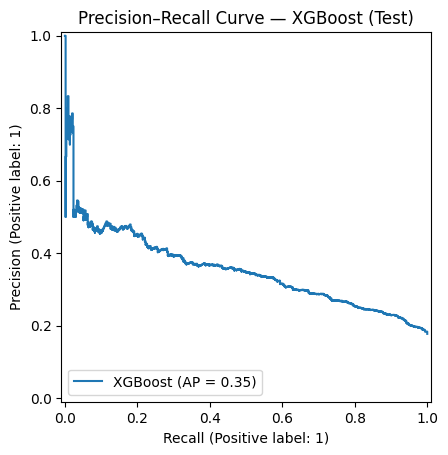

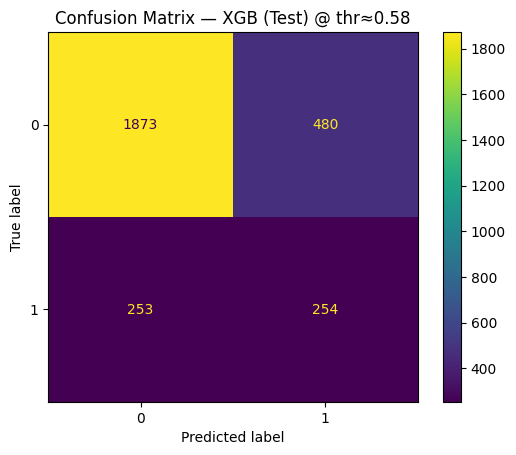

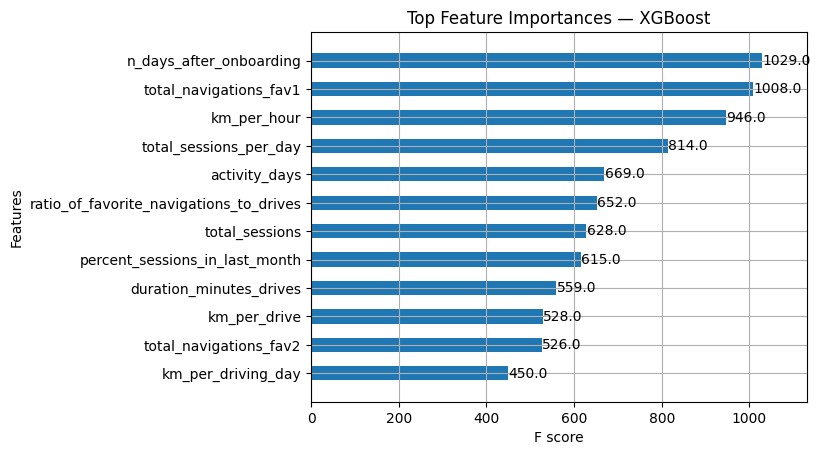

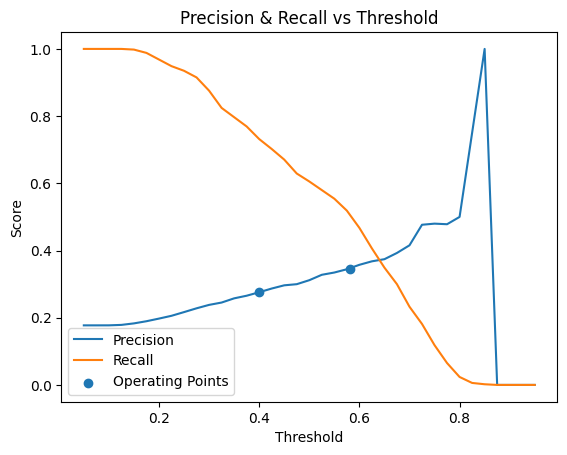

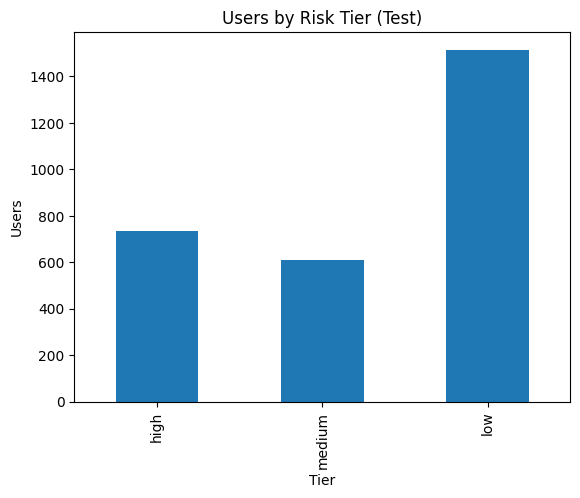

In [ ]:
# Visualizations for README file

# PR Curve
PrecisionRecallDisplay.from_predictions(y_test, test_probs, name="XGBoost")
plt.title("Precision–Recall Curve — XGBoost (Test)")
plt.savefig("../visuals/pr_curve_xgb_test.png", dpi=200, bbox_inches="tight"); plt.show()

# Confusion Matrix @ threshold ~0.58
thr = 0.582
preds = (test_probs >= thr).astype(int)
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, preds))
disp.plot(values_format="d")
plt.title("Confusion Matrix — XGB (Test) @ thr≈0.58")
plt.savefig("../visuals/cm_xgb_test_thr058.png", dpi=200, bbox_inches="tight"); plt.show()

# Feature Importances (Top 12)
plot_importance(xgb_best, max_num_features=12, height=0.5)
plt.title("Top Feature Importances — XGBoost")
plt.savefig("../visuals/feat_importance_xgb_top12.png", dpi=200, bbox_inches="tight"); plt.show()

# Threshold Sweep
ths = np.linspace(0.05, 0.95, 37)
prec, rec = [], []
for t in ths:
    p = (test_probs >= t).astype(int)
    prec.append(precision_score(y_test, p, zero_division=0))
    rec.append(recall_score(y_test, p))
plt.figure()
plt.plot(ths, prec, label="Precision"); plt.plot(ths, rec, label="Recall")
plt.scatter([0.582, 0.4], [
    precision_score(y_test, (test_probs>=0.582).astype(int), zero_division=0),
    precision_score(y_test, (test_probs>=0.4).astype(int), zero_division=0)
], label="Operating Points")
plt.legend(); plt.xlabel("Threshold"); plt.ylabel("Score"); plt.title("Precision & Recall vs Threshold")
plt.savefig("../visuals/threshold_sweep_precision_recall.png", dpi=200, bbox_inches="tight"); plt.show()

# Risk Tiers Bar
risk = pd.cut(test_probs, bins=[-1, 0.40, 0.582, 1.01], labels=["low","medium","high"])
risk.value_counts().loc[["high","medium","low"]].plot(kind="bar")
plt.title("Users by Risk Tier (Test)"); plt.xlabel("Tier"); plt.ylabel("Users")
plt.savefig("../visuals/risk_tiers_bar.png", dpi=200, bbox_inches="tight"); plt.show()